# Visualize XSS and SQL_Injection

In [43]:
from urllib.parse import urlparse, parse_qs
import os
import regex as re 
import nltk
from nltk import ngrams
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
HTTP_RE = re.compile(r"(.+?)\s\n\n", re.MULTILINE | re.DOTALL)
HTTP_RE2 = re.compile(r"(.+?)\n\n(.+?)\n\n", re.MULTILINE | re.DOTALL)


def http_re(data):
    """
    Extracts HTTP requests from raw data string in special logging format.
    Logging format `ST@RT\n%(asctime)s %(levelname)-8s\n%(message)s\nEND`
    where `message` is a required HTTP request bytes.
    """

    tmp_requests = HTTP_RE.findall(data)
    requests=[]
    for i in range(len(tmp_requests)):
        tmp=HTTP_RE2.findall(tmp_requests[i])
        if len(tmp)>0:
            for j in range(len(tmp)):
                temp_str=tmp[j][0]+"\n\n"+tmp[j][1]+"\n"
                requests.append(temp_str)
        else:
            requests.append(tmp_requests[i])
    return requests


def get_requests_from_file(path):
    """
    Reads raw HTTP requests from given file.
    """
    with open(path, 'r') as f:
        file_data = f.read()
    requests = http_re(file_data)
    return requests


def _process_request(req):
    """
    Splits a request into lines and convert a string into ints.
    """
    my_method = ""
    my_uri = "http://127.0.0.1:80"
    dictRequest={}
    my_header = {}
    i = 0
    body = False
    for line in req.splitlines():
        if line=="":
            body=True
        if i == 0 and len(line.split())>2:
            my_method=line.split()[0]
            if line.split()[1].split('localhost:8080')[1].startswith('/') or line.split()[1].split('localhost:8080')[1].startswith('?'):
                my_uri = my_uri + line.split()[1].split('localhost:8080')[1]
        else:
            if not body and len(line.split(':'))>1:
                key = line.split(':')[0].lstrip()
                value = line.split(':')[1].lstrip()
                my_header[key]=value
            else:
                dictRequest['body']=line.split(':')[0]
        #print("-")
        i=i+1
    return my_method, my_uri, my_header, dictRequest

In [17]:
csic_2010_normal_traffic_test_relative_path = '../data/HTTP_dataset_CSIC_2021/normalTrafficTest.txt'

csic_2010_normal_traffic_test_file = os.path.abspath(csic_2010_normal_traffic_test_relative_path)

http_requests = get_requests_from_file(csic_2010_normal_traffic_test_file)
print(f"# of requests: {str(len(http_requests))}")
normal_uri_list = []
for req in http_requests:
    my_method, my_uri, my_header, dictRequest = _process_request(req)
    normal_uri_list.append(my_uri)   

# of requests: 28000


In [22]:
csic_2010_anomalous_traffic_test_relative_path = '../data/HTTP_dataset_CSIC_2021/anomalousTrafficTest.txt'

csic_2010_anomalous_traffic_test_file = os.path.abspath(csic_2010_anomalous_traffic_test_relative_path)

http_requests = get_requests_from_file(csic_2010_anomalous_traffic_test_file)
print(f"# of requests: {str(len(http_requests))}")
attack_uri_list = []
for req in http_requests:
    my_method, my_uri, my_header, dictRequest = _process_request(req)
    attack_uri_list.append(my_uri)   

# of requests: 15246


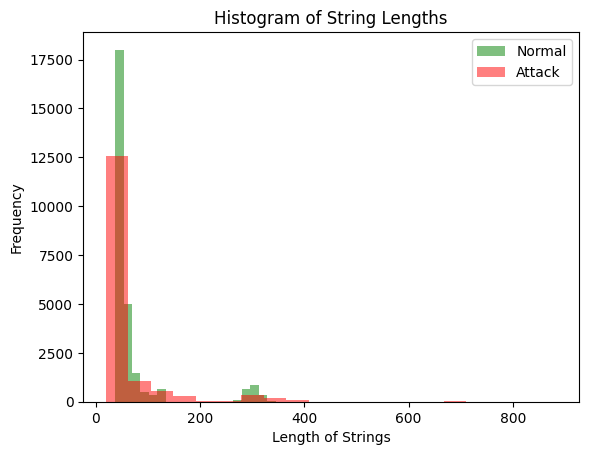

In [23]:
import matplotlib.pyplot as plt

# Calculate the lengths of strings in normal_uri_list and attack_uri_list
normal_lengths = [len(uri) for uri in normal_uri_list]
attack_lengths = [len(uri) for uri in attack_uri_list]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the histogram of normal_uri_list with green bars
ax.hist(normal_lengths, bins=20, color='green', alpha=0.5, label='Normal')

# Plot the histogram of attack_uri_list with red bars
ax.hist(attack_lengths, bins=20, color='red', alpha=0.5, label='Attack')

# Set labels and title
ax.set_xlabel('Length of Strings')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of String Lengths')

# Add a legend
ax.legend()

# Show the plot
plt.show()

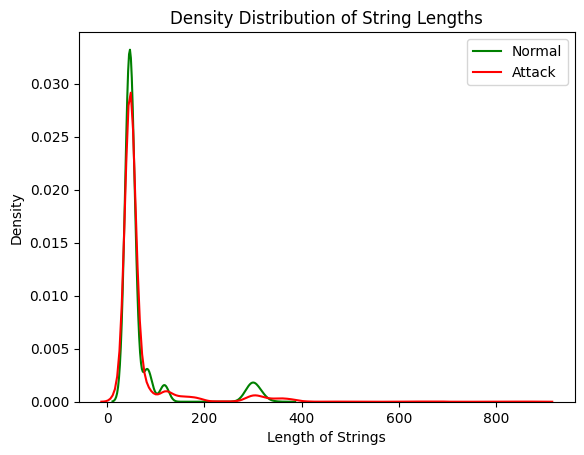

In [24]:
import seaborn as sns

# Create a KDE plot for normal_lengths
sns.kdeplot(normal_lengths, color='green', label='Normal')

# Create a KDE plot for attack_lengths
sns.kdeplot(attack_lengths, color='red', label='Attack')

# Set labels and title
plt.xlabel('Length of Strings')
plt.ylabel('Density')
plt.title('Density Distribution of String Lengths')

# Add a legend
plt.legend()

# Show the plot
plt.show()

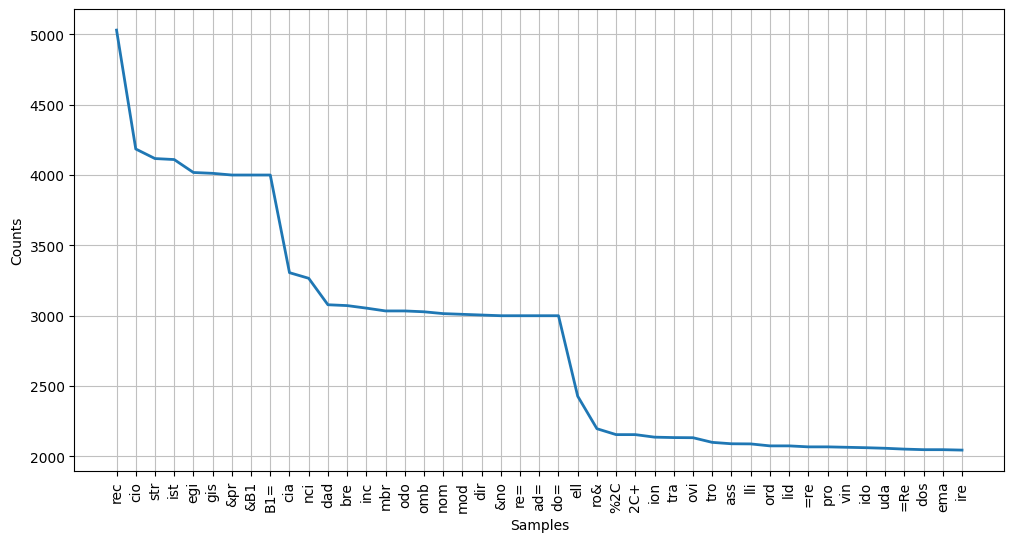

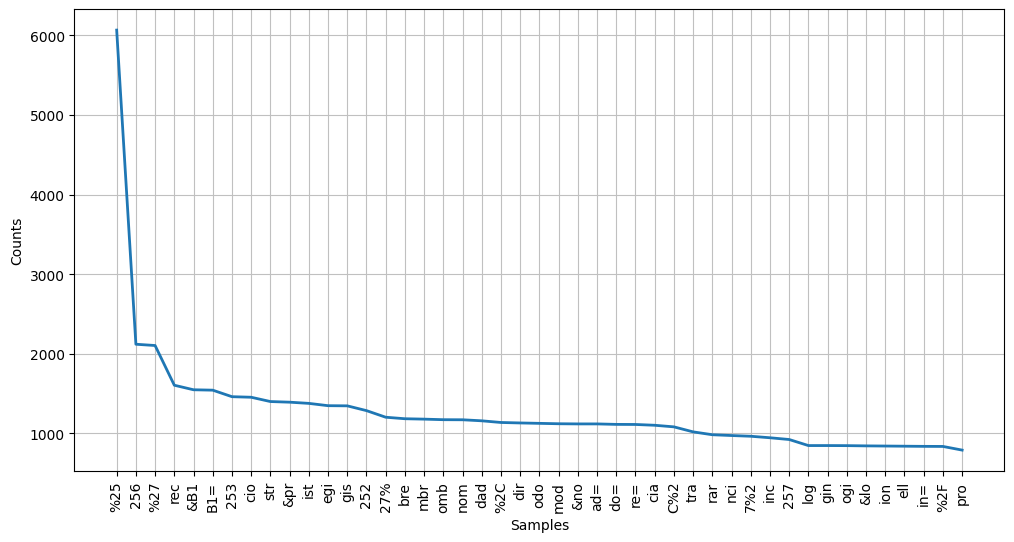

In [42]:
# Split each element in normal_uri_list at the '?' token
split_uris_normal = [uri.split('?')[1] if len(uri.split('?')) > 1 else '' for uri in normal_uri_list]

# Create character trigrams for strings longer than 0
trigrams_normal = [ngrams(uri, 3) for uri in split_uris_normal if len(uri) > 0]

# Flatten the list of trigrams
flattened_trigrams_normal = [trigram for sublist in trigrams_normal for trigram in sublist]

# Convert trigrams to a list of strings
trigram_strings_normal = [''.join(trigram) for trigram in flattened_trigrams_normal]

# Calculate the frequency of 2-gram trigrams for normal_uri_list
trigram_freq_normal = nltk.FreqDist(trigram_strings_normal)

# Plot the histogram of 2-gram trigram frequencies for normal_uri_list
plt.figure(figsize=(12, 6))
trigram_freq_normal.plot(45, cumulative=False)
plt.show()

# Create character trigrams for strings longer than 0 for attack_uri_list
trigrams_attack = [ngrams(uri, 3) for uri in split_uris if len(uri) > 0]

# Flatten the list of trigrams for attack_uri_list
flattened_trigrams_attack = [trigram for sublist in trigrams_attack for trigram in sublist]

# Convert trigrams to a list of strings for attack_uri_list
trigram_strings_attack = [''.join(trigram) for trigram in flattened_trigrams_attack]

# Calculate the frequency of 2-gram trigrams for attack_uri_list
trigram_freq_attack = nltk.FreqDist(trigram_strings_attack)

# Plot the histogram of 2-gram trigram frequencies for attack_uri_list
plt.figure(figsize=(12, 6))
trigram_freq_attack.plot(45, cumulative=False)
plt.show()